In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from transformers import AutoModel, AutoTokenizer

In [2]:
df = pd.read_csv('/kaggle/input/dair-emotion/ai_emotion_dataset.csv')
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    416809 non-null  object
 1   label   416809 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 6.4+ MB
None
                                                text  label
0  i feel awful about it too because it s my job ...      0
1                              im alone i feel awful      0
2  ive probably mentioned this before but i reall...      1
3           i was feeling a little low few days back      0
4  i beleive that i am much more sensitive to oth...      2


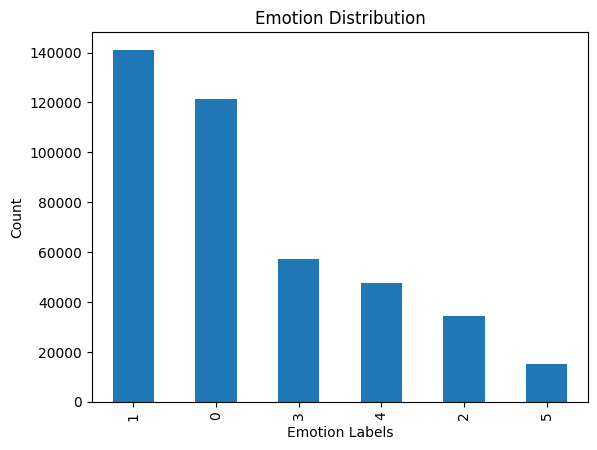

In [3]:
label2int = {
    "sadness": 0,
    "joy": 1,
    "love": 2,
    "anger": 3,
    "fear": 4,
    "surprise": 5
}
emotions = ["sadness", "joy", "love", "anger", "fear", "surprise"]
df['label'].value_counts().plot(kind='bar')
plt.title('Emotion Distribution')
plt.xlabel('Emotion Labels')
plt.ylabel('Count')
plt.show()

In [4]:
# Stratified split into train, validation, and test sets
df_train, df_temp = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label'])
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=42, stratify=df_temp['label'])

print(f"Training set size: {len(df_train)}")
print(f"Validation set size: {len(df_val)}")
print(f"Test set size: {len(df_test)}")

Training set size: 291766
Validation set size: 62521
Test set size: 62522


In [5]:
# Compute class weights
train_labels = df_train['label'].values
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = {label: weight for label, weight in zip(np.unique(train_labels), class_weights)}

print("Class Weights:", class_weights_dict)

Class Weights: {0: 0.5732299120211558, 1: 0.4924470279265868, 2: 2.0104046083457363, 3: 1.2119950816675806, 4: 1.4560053496217338, 5: 4.640044529262086}


In [6]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('distilroberta-base')

sample_text = "This is a sample sentence for tokenization."
tokenized_output = tokenizer(sample_text, padding='max_length', truncation=True, max_length=128)
print(tokenized_output)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

{'input_ids': [0, 713, 16, 10, 7728, 3645, 13, 19233, 1938, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
# Set device: MPS > CUDA > CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple MPS backend for training.")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA backend for training.")
else:
    device = torch.device("cpu")
    print("Using CPU for training.")

Using CUDA backend for training.


In [8]:
#Defining a custom dataset class to handle tokenized text and labels.

import torch
from torch.utils.data import Dataset

class EmotionDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.texts = dataframe['text'].tolist()
        self.labels = dataframe['label'].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].squeeze(0).to(device),
            'attention_mask': encoding['attention_mask'].squeeze(0).to(device),
            'labels': torch.tensor(label, dtype=torch.long).to(device)
        }

    def __len__(self):
        return len(self.labels)


# Create dataset objects
train_dataset = EmotionDataset(df_train, tokenizer)
val_dataset = EmotionDataset(df_val, tokenizer)
test_dataset = EmotionDataset(df_test, tokenizer)

print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")

Training samples: 291766, Validation samples: 62521, Test samples: 62522


In [9]:
#Mish Activation Function

import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModel

class Mish(nn.Module):
    def forward(self, x):
        return x * torch.tanh(F.softplus(x))

In [10]:
class EmoModelWithAttention(torch.nn.Module):
    def __init__(self, base_model, n_classes):
        super().__init__()
        self.base_model = base_model
        self.classifier = torch.nn.Sequential(
            torch.nn.Dropout(0.1),
            torch.nn.Linear(768, 768),
            Mish(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(768, n_classes)
        )
        self.attention_weights = torch.nn.Linear(768, 1)  # Attention score per token

    def forward(self, input_ids, attention_mask):
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state  # Shape: (batch_size, seq_len, hidden_dim)
        
        # Compute attention scores
        attention_scores = self.attention_weights(hidden_states).squeeze(-1)
        attention_scores = attention_scores.masked_fill(attention_mask == 0, float('-inf'))
        attention_weights = F.softmax(attention_scores, dim=1)
        
        # Weighted average of token embeddings
        pooled_output = torch.sum(hidden_states * attention_weights.unsqueeze(-1), dim=1)
        
        return self.classifier(pooled_output)

In [11]:
base_model = AutoModel.from_pretrained('distilroberta-base')

n_classes = df['label'].nunique()

model = EmoModelWithAttention(base_model=base_model, n_classes=n_classes)
model.to(device)

print(model)

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

EmoModelWithAttention(
  (base_model): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNor

In [12]:
from torch.utils.data import DataLoader
BATCH_SIZE = 16

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Verify a batch from the DataLoader
batch = next(iter(train_loader))
print(batch['input_ids'].shape) 
print(batch['attention_mask'].shape) 
print(batch['labels'].shape)  

torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16])


In [13]:
# Print a sample batch
for batch in train_loader:
    print("Input IDs shape:", batch['input_ids'].shape)
    print("Attention Mask shape:", batch['attention_mask'].shape)
    print("Labels shape:", batch['labels'].shape)
    break

Input IDs shape: torch.Size([16, 128])
Attention Mask shape: torch.Size([16, 128])
Labels shape: torch.Size([16])


In [14]:
class_weights_tensor = torch.tensor(list(class_weights_dict.values()), dtype=torch.float).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

def compute_metrics(predictions, labels):
    predictions = predictions.cpu()
    labels = labels.cpu()
    
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='weighted', zero_division=0)
    recall = recall_score(labels, predictions, average='weighted', zero_division=0)
    f1 = f1_score(labels, predictions, average='weighted', zero_division=0)
    
    class_report = classification_report(labels, predictions, target_names=emotions, zero_division=0)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'classification_report': class_report
    }

In [16]:
from tqdm import tqdm

def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=3):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            optimizer.zero_grad()
            
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_train_loss = total_loss / len(train_loader)
        val_loss, metrics = evaluate_model(model, val_loader, criterion)
        
        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {val_loss:.4f}")
        print(f"Accuracy: {metrics['accuracy']:.4f}, Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}, F1-Score: {metrics['f1_score']:.4f}")
        print("Classification Report:\n", metrics['classification_report'])


In [17]:
def evaluate_model(model, val_loader, criterion):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            preds = torch.argmax(outputs, dim=1)  # Get predicted class indices
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())
    
    avg_loss = total_loss / len(val_loader)
    
    # Combine all predictions and labels into single tensors
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    
    metrics = compute_metrics(all_preds, all_labels)
    return avg_loss, metrics

In [18]:
print("Model device:", next(model.parameters()).device)
batch = next(iter(train_loader))
print("Input IDs device:", batch['input_ids'].device)
print("Attention Mask device:", batch['attention_mask'].device)
print("Labels device:", batch['labels'].device)

EPOCHS = 5

# Move model to GPU/MPS if available
model.to(device)

train_model(model, train_loader, val_loader, optimizer, criterion, epochs=EPOCHS)# Save the model

Model device: cuda:0
Input IDs device: cuda:0
Attention Mask device: cuda:0
Labels device: cuda:0


Epoch 1: 100%|██████████| 18236/18236 [1:04:03<00:00,  4.75it/s]


Epoch 1: Train Loss = 0.1633, Val Loss = 0.1150
Accuracy: 0.9383, Precision: 0.9480, Recall: 0.9383, F1-Score: 0.9403
Classification Report:
               precision    recall  f1-score   support

     sadness       1.00      0.95      0.97     18178
         joy       1.00      0.91      0.95     21160
        love       0.77      1.00      0.87      5183
       anger       0.93      0.95      0.94      8597
        fear       0.88      0.91      0.90      7157
    surprise       0.73      1.00      0.84      2246

    accuracy                           0.94     62521
   macro avg       0.89      0.95      0.91     62521
weighted avg       0.95      0.94      0.94     62521



Epoch 2: 100%|██████████| 18236/18236 [1:01:11<00:00,  4.97it/s]


Epoch 2: Train Loss = 0.1105, Val Loss = 0.1058
Accuracy: 0.9398, Precision: 0.9493, Recall: 0.9398, F1-Score: 0.9417
Classification Report:
               precision    recall  f1-score   support

     sadness       1.00      0.95      0.98     18178
         joy       1.00      0.91      0.95     21160
        love       0.77      1.00      0.87      5183
       anger       0.93      0.96      0.94      8597
        fear       0.90      0.90      0.90      7157
    surprise       0.73      1.00      0.84      2246

    accuracy                           0.94     62521
   macro avg       0.89      0.95      0.91     62521
weighted avg       0.95      0.94      0.94     62521



Epoch 3: 100%|██████████| 18236/18236 [1:01:11<00:00,  4.97it/s]


Epoch 3: Train Loss = 0.1043, Val Loss = 0.1073
Accuracy: 0.9404, Precision: 0.9495, Recall: 0.9404, F1-Score: 0.9423
Classification Report:
               precision    recall  f1-score   support

     sadness       1.00      0.95      0.97     18178
         joy       1.00      0.92      0.95     21160
        love       0.77      1.00      0.87      5183
       anger       0.94      0.95      0.95      8597
        fear       0.90      0.90      0.90      7157
    surprise       0.73      1.00      0.84      2246

    accuracy                           0.94     62521
   macro avg       0.89      0.95      0.91     62521
weighted avg       0.95      0.94      0.94     62521



Epoch 4: 100%|██████████| 18236/18236 [1:01:07<00:00,  4.97it/s]


Epoch 4: Train Loss = 0.1019, Val Loss = 0.1066
Accuracy: 0.9402, Precision: 0.9500, Recall: 0.9402, F1-Score: 0.9419
Classification Report:
               precision    recall  f1-score   support

     sadness       1.00      0.95      0.97     18178
         joy       1.00      0.91      0.95     21160
        love       0.77      1.00      0.87      5183
       anger       0.91      0.99      0.95      8597
        fear       0.94      0.86      0.90      7157
    surprise       0.73      1.00      0.84      2246

    accuracy                           0.94     62521
   macro avg       0.89      0.95      0.91     62521
weighted avg       0.95      0.94      0.94     62521



Epoch 5: 100%|██████████| 18236/18236 [1:01:18<00:00,  4.96it/s]


Epoch 5: Train Loss = 0.0998, Val Loss = 0.1069
Accuracy: 0.9407, Precision: 0.9505, Recall: 0.9407, F1-Score: 0.9424
Classification Report:
               precision    recall  f1-score   support

     sadness       1.00      0.95      0.98     18178
         joy       1.00      0.92      0.95     21160
        love       0.77      1.00      0.87      5183
       anger       0.91      0.99      0.95      8597
        fear       0.94      0.86      0.90      7157
    surprise       0.73      1.00      0.84      2246

    accuracy                           0.94     62521
   macro avg       0.89      0.95      0.91     62521
weighted avg       0.95      0.94      0.94     62521



In [19]:
torch.save(model.state_dict(), 'ai_emotion_classification_model.pth')
print("Model saved successfully!")

Model saved successfully!


In [20]:
#Test Eval
test_loss, test_metrics = evaluate_model(model, test_loader, criterion)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")
print(f"Precision: {test_metrics['precision']:.4f}")
print(f"Recall: {test_metrics['recall']:.4f}")
print(f"F1-Score: {test_metrics['f1_score']:.4f}")
print("Classification Report:\n", test_metrics['classification_report'])

Test Loss: 0.1021
Test Accuracy: 0.9428
Precision: 0.9520
Recall: 0.9428
F1-Score: 0.9444
Classification Report:
               precision    recall  f1-score   support

     sadness       1.00      0.95      0.98     18178
         joy       1.00      0.92      0.96     21160
        love       0.77      1.00      0.87      5183
       anger       0.91      1.00      0.95      8598
        fear       0.94      0.87      0.90      7157
    surprise       0.75      1.00      0.86      2246

    accuracy                           0.94     62522
   macro avg       0.90      0.96      0.92     62522
weighted avg       0.95      0.94      0.94     62522



In [21]:
#Inference Example 

def predict_emotion(text, model, tokenizer):
    model.eval()
    encoding = tokenizer(
        text,
        return_tensors='pt',
        truncation=True,
        padding='max_length',
        max_length=128
    )
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        prediction = torch.argmax(outputs, dim=1).cpu().item()
    
    return prediction

# Example prediction
sample_text = "I'm feeling really afraid today!"
emotion = predict_emotion(sample_text, model, tokenizer)
print(f"Predicted Emotion: {emotion}")

Predicted Emotion: 4
